## Import library

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available else 'cpu'

## Import data

In [2]:
batch_size = 256
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], # These are parameter when using z-score normalization
                         [0.2470, 0.2435, 0.2616]),
    transforms.RandomErasing(p=0.75,
                             scale=(0.01, 0.3),
                             ratio=(1.0, 1.0),
                             value=0,
                             inplace =True) # Add noise to the traning data to avoid overfit
])
valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], 
                         [0.2470, 0.2435, 0.2616]),
    
])

train_set = CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform = train_transform
)
val_set = CIFAR10(
    root = './data',
    train = False,
    download = True,
    transform = valid_transform
)

trainloader = DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 4
)
testloader = DataLoader(
    val_set,
    batch_size = batch_size,
    num_workers = 4
)

100%|██████████| 170498071/170498071 [00:02<00:00, 77769586.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


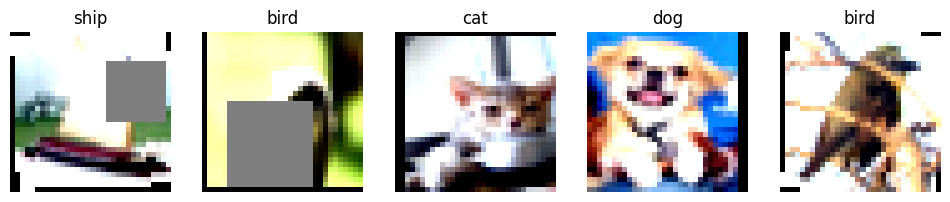

In [3]:
def plot_cifar_images(dataset, num_images=5):
    dataloader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(dataloader))

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    for i, (image, label) in enumerate(zip(images, labels)):
        # Unnormalize the image
        image = image.permute(1, 2, 0) / 2 + 0.5

        axes[i].imshow(image)
        axes[i].set_title(classes[label.item()])
        axes[i].axis('off')

    plt.show()
    
plot_cifar_images(train_set, num_images=5)

These are resulted images when you using data augmentation, and adding noise to the train set. As a result, it makes our data more diversity

## Model

In [4]:
class CNNModel(nn.Module):
    def __init__(self, n_classes=10, dropout_rate=0.3):
        super(CNNModel,self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3,64,3,padding='same'),nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,padding='same'),nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(dropout_rate)
        )
        self.skip1 = nn.Sequential(
            nn.Conv2d(3,64,3,stride=2, padding=1),nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(64,128,3,padding='same'),nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,3,padding='same'),nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.Dropout(dropout_rate)
        )
        self.skip2 = nn.Sequential(
            nn.Conv2d(64,128,3,stride=2, padding=1),nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(128,256,3,padding='same'),nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256,256,3,padding='same'),nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256,256,3,padding='same'),nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.Dropout(dropout_rate)
        )
        self.skip3 = nn.Sequential(
            nn.Conv2d(128,256,3,stride=2, padding=1),nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(256,512,3,padding='same'),nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512,512,3,padding='same'),nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512,512,3,padding='same'),nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2,2),
            nn.Dropout(dropout_rate)
        )
        self.skip4 = nn.Sequential(
            nn.Conv2d(256,512,3,stride=2, padding=1),nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(512*2*2,512),nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )
        self.fc2 = nn.Linear(64,n_classes)
        
    def forward(self,x):
        skip = self.skip1(x)
        x = self.block1(x)
        x = x+skip
        
        skip = self.skip2(x)
        x = self.block2(x)
        x = x+skip
        
        skip = self.skip3(x)
        x = self.block3(x)
        x = x+skip
        
        skip = self.skip4(x)
        x = self.block4(x)
        x = x+skip
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
        

In [5]:
model = CNNModel(10)
model.to(device)
print(model)

CNNModel(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
  )
  (skip1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)

## Train

Using weight decay and Exponential decay learning rate to improve optimization process

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)  
decayRate = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [7]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [8]:
# some parameters
train_losses = []
train_accuracies = []
test_losses = [] 
test_accuracies = []
max_epoch = 250

In [9]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # number of correct predictions
    total = 0             # total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # update learning rate
    lr_scheduler.step()

Epoch [1/250], Loss: 1.5266, Accuracy: 44.29%, Test Loss: 1.1628, Test Accuracy: 58.05%
Epoch [2/250], Loss: 1.1228, Accuracy: 59.81%, Test Loss: 0.8933, Test Accuracy: 68.92%
Epoch [3/250], Loss: 0.9343, Accuracy: 67.01%, Test Loss: 0.7145, Test Accuracy: 75.15%
Epoch [4/250], Loss: 0.8307, Accuracy: 70.94%, Test Loss: 0.6493, Test Accuracy: 77.71%
Epoch [5/250], Loss: 0.7645, Accuracy: 73.34%, Test Loss: 0.6139, Test Accuracy: 79.06%
Epoch [6/250], Loss: 0.7108, Accuracy: 75.50%, Test Loss: 0.5359, Test Accuracy: 81.60%
Epoch [7/250], Loss: 0.6718, Accuracy: 76.75%, Test Loss: 0.4995, Test Accuracy: 82.98%
Epoch [8/250], Loss: 0.6366, Accuracy: 78.01%, Test Loss: 0.5079, Test Accuracy: 82.42%
Epoch [9/250], Loss: 0.6097, Accuracy: 78.83%, Test Loss: 0.4503, Test Accuracy: 84.83%
Epoch [10/250], Loss: 0.5783, Accuracy: 80.08%, Test Loss: 0.4750, Test Accuracy: 84.04%
Epoch [11/250], Loss: 0.5552, Accuracy: 80.72%, Test Loss: 0.4395, Test Accuracy: 84.94%
Epoch [12/250], Loss: 0.5352, 

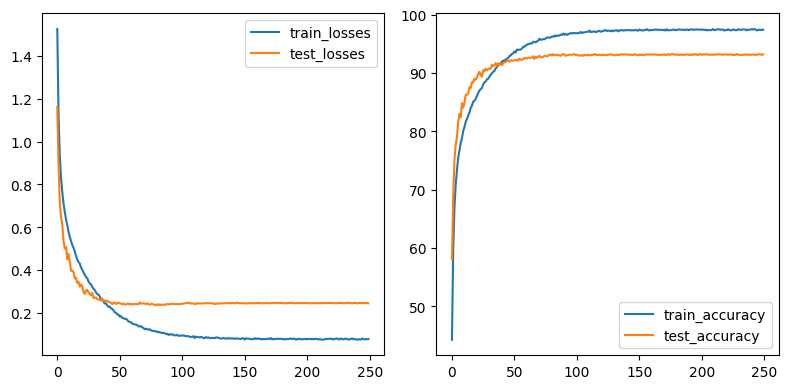

In [10]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(train_losses, label='train_losses')
ax[0].plot(test_losses, label='test_losses')
ax[0].legend()

ax[1].plot(train_accuracies, label='train_accuracy')
ax[1].plot(test_accuracies, label='test_accuracy')
ax[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
